In [235]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader as torch_dataloader
from torch.utils.data import Dataset as torch_dataset
import torch.optim as optim

In [236]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=2, stride=2, padding=2)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=2, stride=2, padding=2)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=2, stride=2, padding=2)
        self.conv4 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=2, stride=2, padding=2)
        self.conv5 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=2, stride=2, padding=2)
        
        self.pool = nn.AvgPool1d(kernel_size=2, stride=2)
        
        
        self.norm3 = nn.BatchNorm1d(64)
        self.norm4 = nn.BatchNorm1d(64)
        self.norm5 = nn.BatchNorm1d(64)
        
        self.fc1 = nn.Linear(512, 512) 
        self.fc2 = nn.Linear(512, 5)

    def forward(self, x):
        # Block 1
        out1 = F.relu(self.conv1(x))

        # Block 2
        out2 = F.relu(self.conv2(out1))

        # Block 3
        pool1 = self.pool(out1)
        out2_resized = F.interpolate(out2, size=pool1.shape[2], mode='linear', align_corners=True)
        add1 = pool1 + out2_resized
        norm1 = self.norm3(add1)
        out3 = F.relu(self.conv3(norm1))

        # Block 4
        pool2 = self.pool(out2)
        out3_resized = F.interpolate(out3, size=pool2.shape[2], mode='linear', align_corners=True)
        add2 = pool2 + out3_resized
        norm2 = self.norm4(add2)
        out4 = F.relu(self.conv4(norm2))

        # Block 5
        pool3 = self.pool(out3)
        out4_resized = F.interpolate(out4, size=pool3.shape[2], mode='linear', align_corners=True)
        add3 = pool3 + out4_resized
        norm3 = self.norm5(add3)
        out5 = F.relu(self.conv5(norm3))

        # Flatten
        out_flat = torch.flatten(out5, 1)

        # Fully connected layers
        out_fc1 = F.relu(self.fc1(out_flat))
        out_fc2 = self.fc2(out_fc1)

        return out_fc2

In [237]:
#debug your network here
#make sure it works for one single input sample
model=Net()
#x=torch.rand(10,187) # if network is MLP
x=torch.rand(10,1,187) #if network is CNN
z=model(x)

In [238]:
def save_checkpoint(filename, model, optimizer, result, epoch):
    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'result':result},
               filename)
    print('saved:', filename)

In [239]:
def cal_accuracy(confusion):
    #input: confusion is the confusion matrix
    #output: acc is the standard classification accuracy
    M=confusion.copy().astype('float32')
    acc = M.diagonal().sum()/M.sum()    
    sens=np.zeros(M.shape[0])
    prec=np.zeros(M.shape[0]) 
    for n in range(0, M.shape[0]):
        TP=M[n,n]
        FN=np.sum(M[n,:])-TP
        FP=np.sum(M[:,n])-TP
        sens[n]=TP/(TP+FN)
        prec[n]=TP/(TP+FP)       
    return acc, sens, prec

In [240]:
def train(model, device, optimizer, dataloader, epoch):    
    model.train()#set model to training mode
    loss_train=0
    acc_train =0 
    sample_count=0
    for batch_idx, (X, Y) in enumerate(dataloader):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()#clear grad of each parameter
        Z = model(X)#forward pass
        loss = nnF.cross_entropy(Z, Y)
        loss.backward()#backward pass
        optimizer.step()#update parameters
        loss_train+=loss.item()
        #do not need softmax
        Yp = Z.data.max(dim=1)[1]  # get the index of the max               
        acc_train+= torch.sum(Yp==Y).item()
        sample_count+=X.size(0)
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{:.0f}%]\tLoss: {:.6f}'.format(
                    epoch, 100. * batch_idx / len(dataloader), loss.item()))
    loss_train/=len(dataloader)
    #due to upsampling, len(dataloader.dataset) != sample_count
    #acc_train/=len(dataloader.dataset) 
    acc_train/=sample_count    
    return loss_train, acc_train

In [241]:
def test(model, device, dataloader):
    model.eval()#set model to evaluation mode
    acc_test =0
    confusion=np.zeros((5,5))
    with torch.no_grad(): # tell Pytorch not to build graph in the with section
        for batch_idx, (X, Y) in enumerate(dataloader):
            X, Y = X.to(device), Y.to(device)
            Z = model(X)#forward pass
            #do not need softmax
            Yp = Z.data.max(dim=1)[1]  # get the index of the max 
            acc_test+= torch.sum(Yp==Y).item()
            for i in range(0, 5):
                for j in range(0, 5):
                    confusion[i,j]+=torch.sum((Y==i)&(Yp==j)).item()
    acc, sens, prec=cal_accuracy(confusion)
    return acc, (confusion, sens, prec)

In [263]:
class MyDataset(torch_dataset):
    def __init__(self, X, Y):
        self.X=X
        self.Y=Y
    def __len__(self):
        #return the number of data points
        return self.X.shape[0]
    def __getitem__(self, idx):        
        #we can use DatasetName[idx] to get a data point (x,y) with index idx
        x=torch.tensor(self.X[idx], dtype=torch.float32)
        y=torch.tensor(self.Y[idx], dtype=torch.int64)
        x=x.reshape(1,-1)#if network is CNN
        return x, y

In [264]:
import pandas as pd
X=pd.read_csv('ECG_dataX.csv')
Y=pd.read_csv('ECG_dataY.csv')

In [265]:
#convert dataframe to numpy array
X=X.values
X.shape

(3841, 187)

In [266]:
#convert dataframe to numpy array
Y=Y.values
Y.shape

(3841, 1)

In [267]:
#reshape Y into a 1D array
Y=Y.reshape(-1)
Y.shape

(3841,)

(array([800.,   0., 800.,   0.,   0., 800.,   0., 641.,   0., 800.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

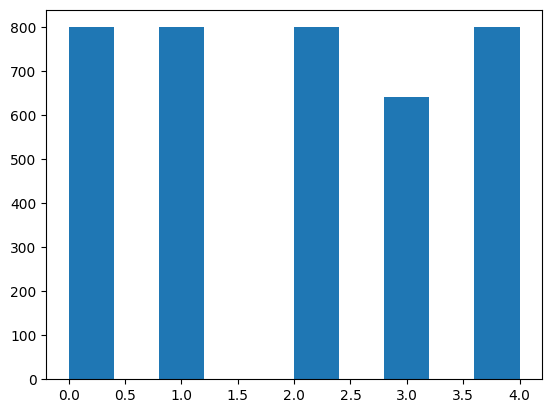

In [268]:
plt.hist(Y)

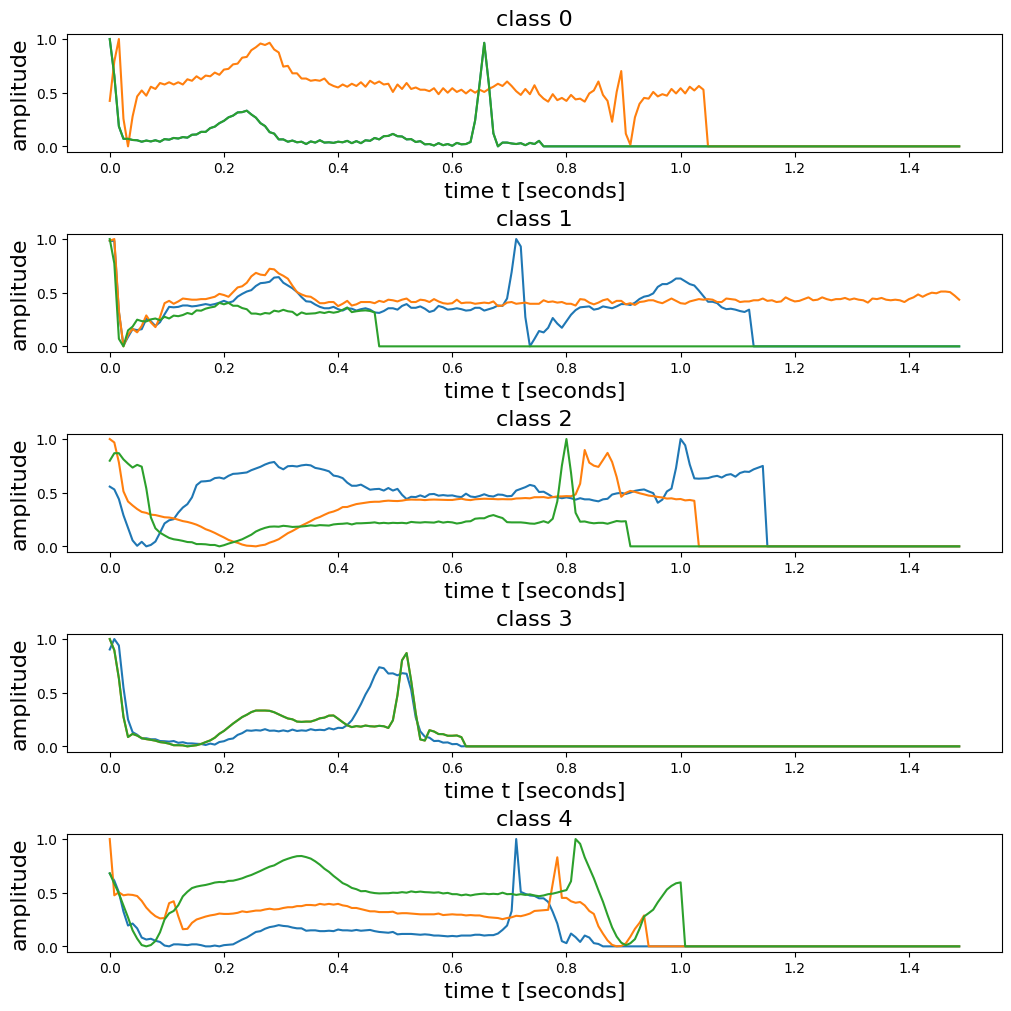

In [269]:
fs=125  # sampling frequency
Ts=1/fs # sampling interval
N=187 # the number of timepoints
Duration=N*Ts # duration of a signal
t=np.linspace(0, Duration-Ts, N) # array of timepoints
fig, ax = plt.subplots(5,1,constrained_layout=True, figsize=(10,10))
for c in range(0, 5):   
    for n in range(0, 3):
        idx=np.random.randint(0,10)
        ax[c].plot(t, X[Y==c][idx])        
        ax[c].set_xlabel('time t [seconds]', fontsize=16)
        ax[c].set_ylabel('amplitude', fontsize=16)
    ax[c].set_title('class '+str(c), fontsize=16)

In [270]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=0)

In [271]:
dataset_train=MyDataset(X_train, Y_train)
dataset_val=MyDataset(X_val, Y_val)
dataset_test=MyDataset(X_test, Y_test)

In [272]:
loader_train = torch_dataloader(dataset_train, batch_size=128, shuffle=True, num_workers=0)
loader_val = torch_dataloader(dataset_val, batch_size=128, shuffle=False, num_workers=0) 
loader_test = torch_dataloader(dataset_test, batch_size=128, shuffle=False, num_workers=0) 

In [273]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model=Net()
model.to(device)


Net(
  (conv1): Conv1d(1, 64, kernel_size=(2,), stride=(2,), padding=(2,))
  (conv2): Conv1d(64, 64, kernel_size=(2,), stride=(2,), padding=(2,))
  (conv3): Conv1d(64, 64, kernel_size=(2,), stride=(2,), padding=(2,))
  (conv4): Conv1d(64, 64, kernel_size=(2,), stride=(2,), padding=(2,))
  (conv5): Conv1d(64, 64, kernel_size=(2,), stride=(2,), padding=(2,))
  (pool): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (norm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=5, bias=True)
)

In [274]:
optimizer = optim.Adamax(model.parameters(), lr=0.001, weight_decay=1e-4)

In [275]:
loss_train_list=[]
acc_train_list=[]
acc_val_list=[]
epoch_save=-1

In [276]:
for epoch in range(epoch_save+1, 100): #change 100 to a larger number if necessary
    #-------- training --------------------------------
    loss_train, acc_train =train(model, device, optimizer, loader_train, epoch)    
    loss_train_list.append(loss_train)
    acc_train_list.append(acc_train)
    print('epoch', epoch, 'training loss:', loss_train, 'acc:', acc_train)
    #-------- validation --------------------------------
    acc_val, other_val = test(model, device, loader_val)
    acc_val_list.append(acc_val)
    print('epoch', epoch, 'validation acc:', acc_val)
    #--------save model-------------------------
    result = (loss_train_list, acc_train_list, 
              acc_val_list, other_val)
    save_checkpoint('ECG_MLP_Pytorch_epoch'+str(epoch)+'.pt', model, optimizer, result, epoch)
    epoch_save=epoch

Train Epoch: 0 [0%]	Loss: 1.610451
epoch 0 training loss: 1.0822833261706613 acc: 0.6324167872648335
epoch 0 validation acc: 0.22727273
saved: ECG_MLP_Pytorch_epoch0.pt
Train Epoch: 1 [0%]	Loss: 0.555193


/var/folders/n2/tjkny83s6vv2353dkdjnr36w0000gn/T/ipykernel_22992/3076453557.py:13: RuntimeWarning: invalid value encountered in scalar divide
  prec[n]=TP/(TP+FP)


epoch 1 training loss: 0.6155921600081704 acc: 0.7680897250361794
epoch 1 validation acc: 0.32792208
saved: ECG_MLP_Pytorch_epoch1.pt
Train Epoch: 2 [0%]	Loss: 0.469299
epoch 2 training loss: 0.5029018250378695 acc: 0.8078871201157742
epoch 2 validation acc: 0.6980519
saved: ECG_MLP_Pytorch_epoch2.pt
Train Epoch: 3 [0%]	Loss: 0.528759
epoch 3 training loss: 0.44041682373393665 acc: 0.8263386396526773
epoch 3 validation acc: 0.79545456
saved: ECG_MLP_Pytorch_epoch3.pt
Train Epoch: 4 [0%]	Loss: 0.422525
epoch 4 training loss: 0.3919096453623338 acc: 0.85383502170767
epoch 4 validation acc: 0.7987013
saved: ECG_MLP_Pytorch_epoch4.pt
Train Epoch: 5 [0%]	Loss: 0.414495
epoch 5 training loss: 0.3593458187851039 acc: 0.863603473227207
epoch 5 validation acc: 0.8279221
saved: ECG_MLP_Pytorch_epoch5.pt
Train Epoch: 6 [0%]	Loss: 0.347192
epoch 6 training loss: 0.3252018080516295 acc: 0.8773516642547033
epoch 6 validation acc: 0.8181818
saved: ECG_MLP_Pytorch_epoch6.pt
Train Epoch: 7 [0%]	Loss: 0

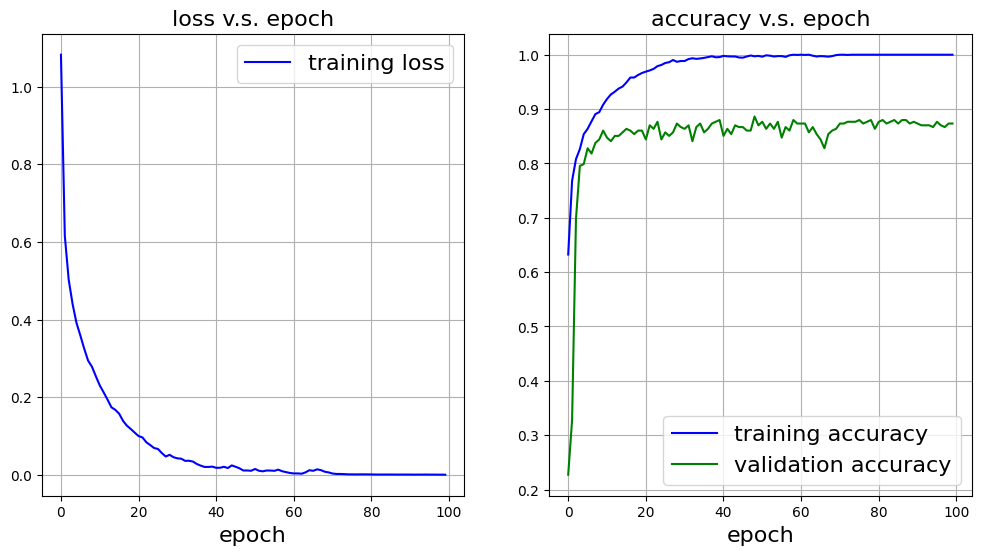

In [277]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].set_title('loss v.s. epoch',fontsize=16)
ax[0].plot(loss_train_list, '-b', label='training loss')
ax[0].set_xlabel('epoch',fontsize=16)
ax[0].legend(fontsize=16)
ax[0].grid(True)
ax[1].set_title('accuracy v.s. epoch',fontsize=16)
ax[1].plot(acc_train_list, '-b', label='training accuracy')
ax[1].plot(acc_val_list, '-g', label='validation accuracy')
ax[1].set_xlabel('epoch',fontsize=16)
ax[1].legend(fontsize=16)
ax[1].grid(True)

In [278]:
best_epoch=np.argmax(acc_val_list)
best_epoch

48

In [279]:
checkpoint=torch.load('ECG_MLP_Pytorch_epoch'+str(best_epoch)+'.pt')
model=Net()
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device);
model.eval();

In [280]:
acc, (confusion, sens, prec) = test(model, device, loader_test)
print('Accuracy (average)', acc)
print('Sensitivity', sens)
print('Precision', prec)
print('Confusion \n', confusion)

Accuracy (average) 0.9050715
Sensitivity [0.81818181 0.91558444 0.92465752 0.90983605 0.9649123 ]
Precision [0.87804878 0.81976742 0.93103451 0.93277311 0.97633135]
Confusion 
 [[144.  26.   2.   3.   1.]
 [ 10. 141.   1.   1.   1.]
 [  4.   1. 135.   4.   2.]
 [  5.   0.   6. 111.   0.]
 [  1.   4.   1.   0. 165.]]
